This notebook will quantify how accurately different parameters of a CF-FM call can be measured by the ```measure_horseshoe_bat_calls``` package. 

This is the second round of tests where I've made significant changes to the package. 

-- 2020-04-18


### Stress-testing the package: how accurate is it really?

With the ```simulate_calls```  module of the package, there's a lot of flexibility in what kinds of calls can be simulated. Here let's run through a range of:

* Call durations
* CF properties : peak frequency, duration
* FM properties : terminal frequency (bandwidth), duration

We will *not* be testing more basic parameters such as rms or energy because it is assumed that if the call parts are segmented correctly, the rest of the parameters will be matched correctly too. 

In [1]:
%matplotlib notebook

In [2]:
from IPython.display import Audio

In [3]:
import numpy as np 
import pandas as pd
import scipy.signal as signal
from tqdm import trange, tqdm
import measure_horseshoe_bat_calls 
from measure_horseshoe_bat_calls.view_horseshoebat_call import *
from measure_horseshoe_bat_calls.segment_horseshoebat_call import *
from measure_horseshoe_bat_calls.simulate_calls import make_cffm_call, make_fm_chirp, silence, make_tone
from measure_horseshoe_bat_calls.signal_processing import get_peak_frequency, get_frequency_resolution
import measure_horseshoe_bat_calls.user_interface as ui

In [4]:
# Note the version of the package being run
measure_horseshoe_bat_calls.__version__

'0.0.1'

### An synthetic call example: 
Synthetic calls are the way to go in testing the accuracy of the package because we do not know *a priori* what the vocalisations of an animal call will be like, or what it should be like. Thus, the only way to convincingly test the performance of a tool like this is through simulation. 

<IPython.core.display.Javascript object>


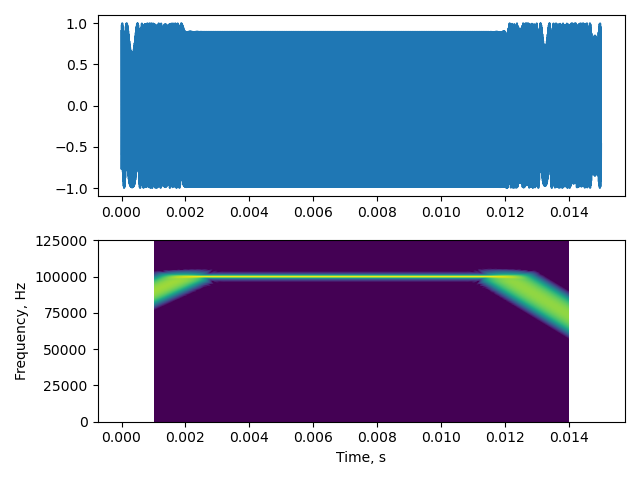

(0.0, 125000.0)

In [5]:
call_parameters = {'cf':(100000, 0.01),
                    'upfm':(80000, 0.002),
                    'downfm':(60000, 0.003),
                    }

fs = 250*10**3 # 500kHz sampling rate
synthetic_call, freq_profile = make_cffm_call(call_parameters, fs)

# plot
wavef, spec = visualise_call(synthetic_call, fs, fft_size=512)
spec.set_ylim(0,125000)

### Test parameter space :

Let us now test the performance of the package with audio clips containing only a single call, with no noise or any silent background. This test run will quantify the call-part segmentation (CF-FM).

In [6]:
cf_durations = [0.005, 0.010, 0.015]
cf_peakfreq = [40000]#, 60000, 90000]
fm_durations = [0.001] # 0.001, 0.002,
fm_bw = [5000]#10000, 20000]

In [7]:
all_combinations = np.array(np.meshgrid(cf_peakfreq, cf_durations,
                                        fm_bw,fm_durations,
                                        np.flip(fm_bw),np.flip(fm_durations)))
all_params = all_combinations.flatten().reshape(6,-1).T

col_names = ['cf_peak_frequency', 'cf_duration',
             'upfm_bw', 'upfm_duration',
             'downfm_bw', 'downfm_duration']

parameter_space = pd.DataFrame(all_params, columns=col_names)
parameter_space['upfm_terminal_frequency'] = parameter_space['cf_peak_frequency'] - parameter_space['upfm_bw']
parameter_space['downfm_terminal_frequency'] = parameter_space['cf_peak_frequency'] - parameter_space['downfm_bw']

In [8]:
parameter_space

,cf_peak_frequency,cf_duration,upfm_bw,upfm_duration,downfm_bw,downfm_duration,upfm_terminal_frequency,downfm_terminal_frequency
0,40000.0,0.005,5000.0,0.001,5000.0,0.001,35000.0,35000.0
1,40000.0,0.010,5000.0,0.001,5000.0,0.001,35000.0,35000.0
2,40000.0,0.015,5000.0,0.001,5000.0,0.001,35000.0,35000.0


In [9]:
parameter_columns = ['cf_peak_frequency', 'cf_duration',
                     'upfm_terminal_frequency', 'upfm_duration',
                     'downfm_terminal_frequency', 'downfm_duration']

In [10]:
all_calls = {}
for row_number, parameters in tqdm(parameter_space.iterrows(),
                                   total=parameter_space.shape[0]):

    cf_peak, cf_durn, upfm_terminal, upfm_durn, downfm_terminal, downfm_durn = parameters[parameter_columns]
    call_parameters = {'cf':(cf_peak, cf_durn),
                        'upfm':(upfm_terminal, upfm_durn),
                        'downfm':(downfm_terminal, downfm_durn),
                        }

    fs = 500*10**3 # 500kHz sampling rate
    synthetic_call, _ = make_cffm_call(call_parameters, fs)
    synthetic_call *= signal.tukey(synthetic_call.size, 0.01)
    all_calls[row_number] = synthetic_call


100%|█| 3/3


In [11]:
parameter_space.shape

(3, 8)

In [12]:
freq_resolution_columns = ['cf_peakfreq_resolution', 'downfm_terminalfreq_resolution',
                          'upfm_terminalfreq_resolution']

In [13]:
accuracy = parameter_space.copy()

In [24]:
common_parameters = {
        'segment_method':'pwvd',
        'fmrate_threshold':2,
        'percentile' : 99.5,
        'max_acc':10}

all_measures = []
seg_outputs = {}
for call_number in trange(parameter_space.shape[0]):
    output = ui.segment_and_measure_call(all_calls[call_number], fs, **common_parameters)
                                        
    seg_output, call_parts, measurements= output
    measurements['call_number'] = call_number
    all_measures.append(measurements)
    seg_outputs[call_number] = seg_output[-1]
    #this_call_msmts = pd.DataFrame(measurements, index=[call_number])
    #measurement_accuracy =  this_call_msmts.loc[call_number,parameter_columns]/parameter_space.loc[call_number,parameter_columns]
    #accuracy.loc[call_number,parameter_columns] = measurement_accuracy


100%|█| 3/3


In [138]:
class itsFMInspector:
    '''
    Handles the output from measure_and_segment calls, and allows plotting
    of the outputs. 
    
    Parameters
    ----------
    segmeasure_out : tuple
        Tuple object containing three other objects which are the output from segment_and_measure_call
        1. segmentation_output : tuple
            Tuple with the `cf` boolean array, `fm` boolean array and `info` dictioanry
        2. audio_parts : dictionary 
            Dictionary with call part labels and values as selected audio parts as np.arrays
        3. measurements : pd.DataFrame
            A wide-formate dataframe with one row referring to meaurements done on one call part
            eg. if a call has 3 parts (fm1, cf1, fm2), then there will be three columns and 
            N columns, if N measurements have been done. 

    whole_audio :  np.array
        The audio that was analysed. 
    
    fs : float>0
        Sampling rate in Hz. 

    Notes
    ----
    * Not all `visualise` methods may be supported. It depends on the segmentation method at hand. 
    * All `visualise` methods return one/multiple subplots that could be used and embellished further
      for your own custom laying over.
    
    '''
    def __init__(self, segmeasure_out, whole_audio, fs, **kwargs):
        self.seg_details, self.audio_parts, self.measurements = segmeasure_out
        self.whole_audio = whole_audio
        self.fs = fs
        self.kwargs = kwargs
        self.cf, self.fm, self.info = self.seg_details 
        
        
    def visualise_audio(self):
        w, s = visualise_call(self.whole_audio, self.fs, **self.kwargs)
        return w,s 
    
    def visualise_fmrate(self):
        '''
        Plots the spectrogram + FM rate profile in a 2 row plot
        '''
        try:
            self.fmrate = self.info['fmrate']
            plt.figure()
            a = plt.subplot(211)
            plt.title('FM Rate')
            make_specgram(self.whole_audio, self.fs, **self.kwargs)
            b = plt.subplot(212, sharex=a)
            make_waveform(self.fmrate, fs)
            plt.ylabel('FM rate, kHz/ms')
            return a,b 
        except:
            raise AttributeError('No fmrate variable found in the output!')

    def visualise_accelaration(self):
        '''
        Plots the spectrogram + accelaration of the 
        frequency profile
        in a 2 row plot
        '''
        try:
            self.acc_profile = self.info['acc_profile']

            plt.figure()
            a = plt.subplot(211)
            plt.title('FM Rate')
            make_specgram(self.whole_audio, self.fs, **self.kwargs)
            b = plt.subplot(212, sharex=a)
            make_waveform(self.acc_profile, fs)
            plt.ylabel('Accelaration, $kHz/ms^{2}$')
            return a,b 
        except:
            raise AttributeError('No accelaration variable found in the output!')

    def visualise_cffm_segmentation(self):
        '''
        '''
        w,s = visualise_cffm_segmentation(self.cf, self.fm, 
                                    self.whole_audio, self.fs,
                                   **self.kwargs)
        return w,s
    
    def visualise_frequency_profiles(self, fp_type='all'):
        '''
        Visualises either one or all of the frequency profiles that are present in the 
        info dictionary. 
        The function relies on picking up all keys in the info dictionary that end with '<>_fp'
        pattern. 
        
        Parameters
        ----------
        fp_type : str/list with str's
            Needs to correspond to a key found in the info dictionary 
        '''
        if fp_type=='all':
            all_fps = self._get_fp_keys(self.info)
        elif isinstance(fp_type, str):
            all_fps = [fp_type]
    
        fig,ax = plt.subplots()
        s = make_specgram(self.whole_audio, self.fs, **self.kwargs);
        time_axis = make_x_time(self.whole_audio, self.fs)
        for each_fp in all_fps:
            plt.plot(time_axis, self.info[each_fp], label=each_fp)
        plt.legend()
        return ax
    
    def visualise_geq_signallevel(self):
        '''
        Some tracking/segmentation methods rely on using only
        regions that are above a threshold, the `signal_level`
        . A moving dB rms window is pass
        
        ed, and only regions above it are 
        
        '''
        fig,ax = plt.subplots()
        s = make_specgram(self.whole_audio, self.fs, **self.kwargs);
        time_axis = make_x_time(self.whole_audio, self.fs)
        ymin, ymax = ax.get_ylim()
        
        above_siglevel = np.zeros(self.whole_audio.size)
        
        for each in self.info['geq_signal_level']:
            above_siglevel[each] = 1 
        plt.plot(time_axis, above_siglevel*ymax*0.5 label='$\geq$ signal level')
        plt.legend()
        return ax
        
    
    def _get_fp_keys(self, info_dictionary):
        fp_keys = list(filter(lambda x : '_fp' in x ,info_dictionary.keys()))
        print(fp_keys)
        if len(fp_keys)==0:
            raise ValueError("There's no frequency profile (fp) in the output info. Check the output object or method")
        return fp_keys
        



In [139]:
info['geq_signal_level']

[(slice(0, 8499, None),)]

In [140]:
isinstance('a', str)

True

<IPython.core.display.Javascript object>


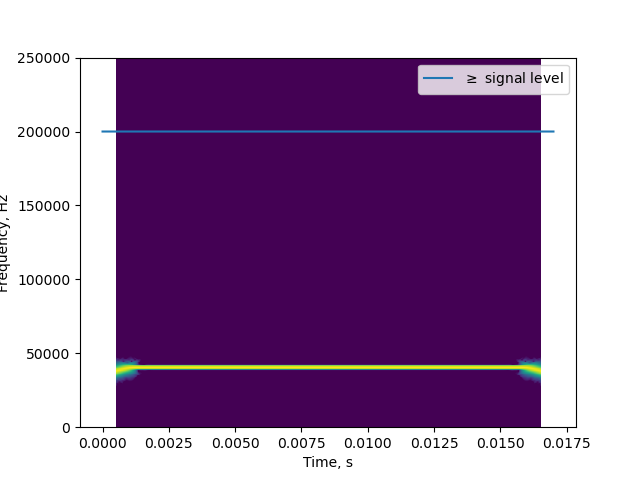

In [141]:
out = itsFMInspector(output, all_calls[2], fs)
out.visualise_geq_signallevel()

<IPython.core.display.Javascript object>


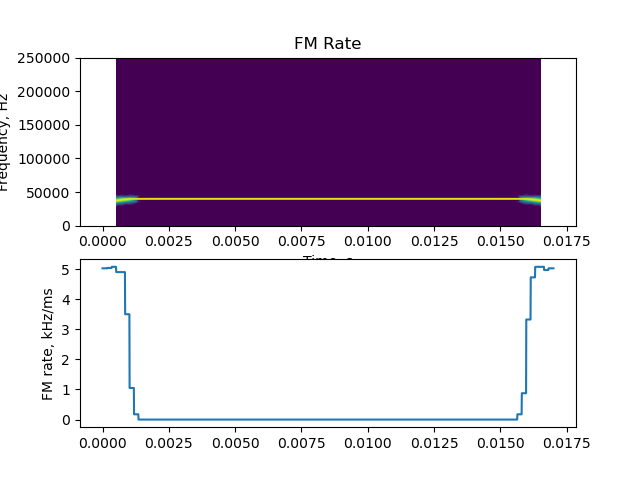

<IPython.core.display.Javascript object>


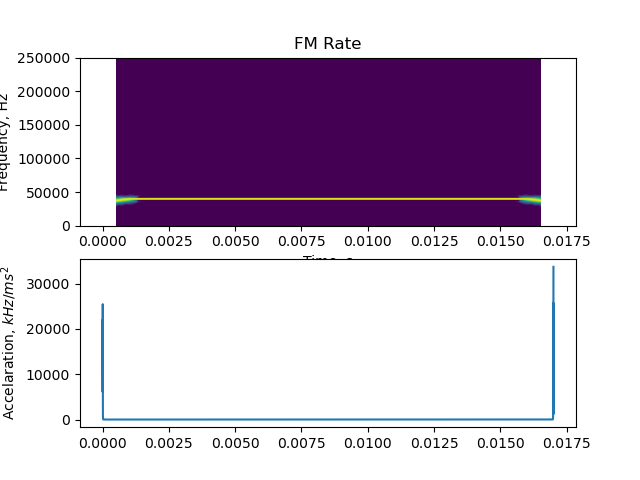

<IPython.core.display.Javascript object>


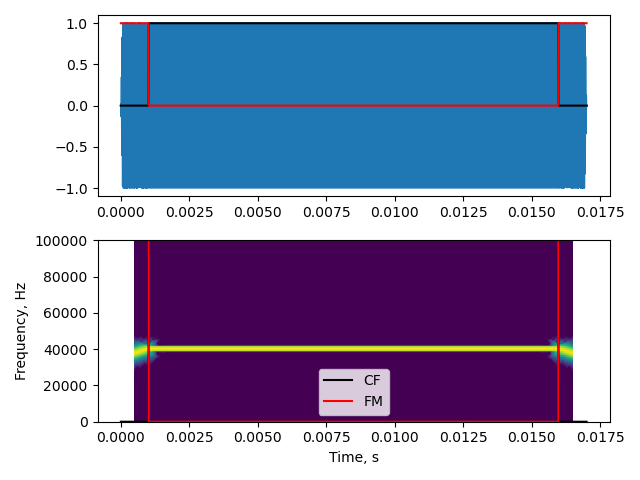

<IPython.core.display.Javascript object>


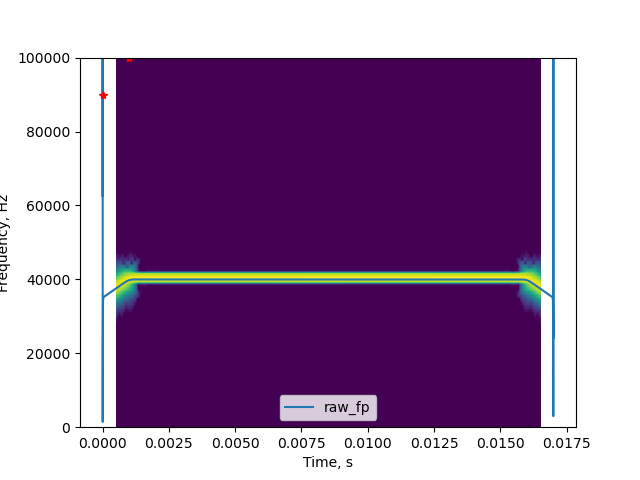

(0.0, 100000.0)

In [116]:
out.visualise_fmrate()
out.visualise_accelaration()
w,s = out.visualise_cffm_segmentation()
s.set_ylim(0,100000)
q = out.visualise_frequency_profiles('raw_fp')
q.plot([0,0.001], [90000,100000],'r*')
q.set_ylim(0,100000)

(0.0, 100000.0)

In [40]:
cf, fm, info = seg_output

In [41]:
info.keys()

dict_keys(['moving_dbrms', 'geq_signal_level', 'raw_fp', 'acc_profile', 'spikey_regions', 'fmrate', 'cleaned_fp', 'fitted_fp'])

In [15]:
final_measurement_set = pd.concat(all_measures).reset_index(drop=True)

In [16]:
final_measurement_set

,start,stop,duration,region_id,call_number
0,0.000000,0.001056,0.001056,fm1,0
1,0.001056,0.005888,0.004832,cf1,0
2,0.005888,0.007000,0.001112,fm2,0
3,0.000000,0.001086,0.001086,fm1,1
4,0.001086,0.010928,0.009842,cf1,1
5,0.010928,0.012000,0.001072,fm2,1
6,0.000000,0.001016,0.001016,fm1,2
7,0.001016,0.015966,0.014950,cf1,2
8,0.015966,0.016998,0.001032,fm2,2


<IPython.core.display.Javascript object>


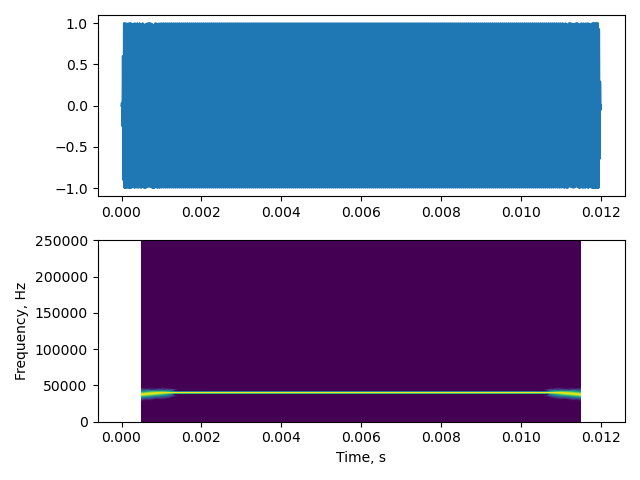

(<matplotlib.axes._subplots.AxesSubplot at 0x14f81108>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14fc4908>)

In [17]:
visualise_call(all_calls[1],fs)

In [18]:
d = seg_outputs[0]


<IPython.core.display.Javascript object>


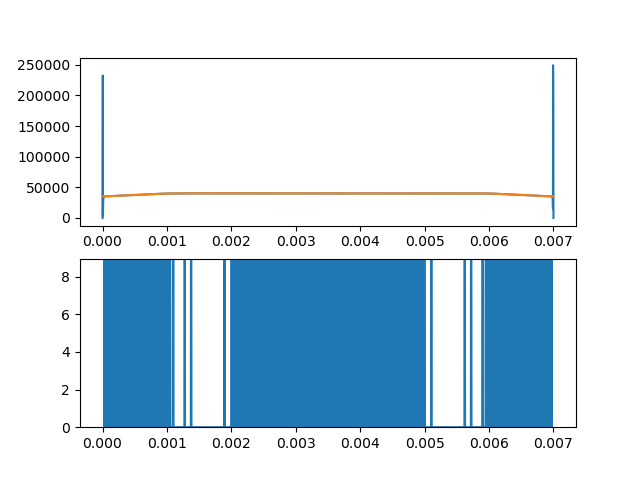

<IPython.core.display.Javascript object>


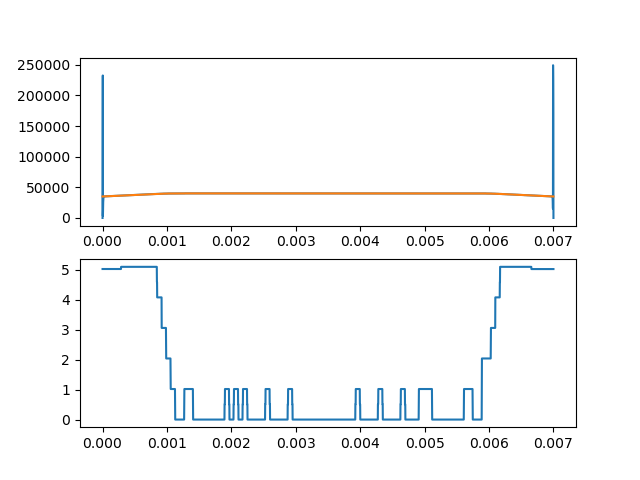

In [25]:
plt.figure()
a = plt.subplot(211)
make_waveform(d['raw_fp'],fs)
make_waveform(d['cleaned_fp'],fs)
#make_waveform(d['fitted_fp'],fs)
plt.plot()
plt.subplot(212, sharex=a)
make_waveform(d['acc_profile'], fs)
plt.ylim(0,np.percentile(d['acc_profile'], 95))

plt.figure()
a = plt.subplot(211)
make_waveform(d['raw_fp'],fs)
make_waveform(d['cleaned_fp'],fs)
#make_waveform(d['fitted_fp'],fs)
plt.plot()
plt.subplot(212, sharex=a)
make_waveform(d['fmrate'], fs)

In [31]:
call_props = {'cf':(9000, 0.010),
             'upfm':(3000, 0.001),
             'downfm':(2000,0.003)}
# downfm has a fmrate of 15kHz/ms
# upfm has an fmrate of 10kHz/ms
fs = 44100
synth_call, freq_profile = make_cffm_call(call_props, fs)

In [32]:
Audio(synth_call, rate=fs)

In [33]:
output = ui.segment_and_measure_call(synth_call, fs,
                                         segment_method='pwvd',
                                          fmrate_threshold=0.05,
                                         sample_every=0.1*10**-3
                                        )
seg_output, call_parts, measurements, backg_output = output

In [26]:
measurements

,start,stop,duration,region_id
0,0.00000,0.001270,0.001270,fm1
1,0.00127,0.010680,0.009410,cf1
2,0.01068,0.013968,0.003288,fm2


In [27]:
noisy_synth_call = synth_call + np.random.normal(0,10**-(20/20.0),synth_call.size)
noisy_synth_call /= np.max(np.abs(noisy_synth_call))

# add a sweep just for fun
sweep = make_fm_chirp(100, 5000, 0.005, fs)

noisy_w_sweep = np.concatenate((synth_call, silence(0.002,fs),
                                sweep))
noisy_w_sweep += np.random.normal(0,10**(-20/20),noisy_w_sweep.size)
noisy_w_sweep /= np.max(np.abs(noisy_w_sweep))

<IPython.core.display.Javascript object>


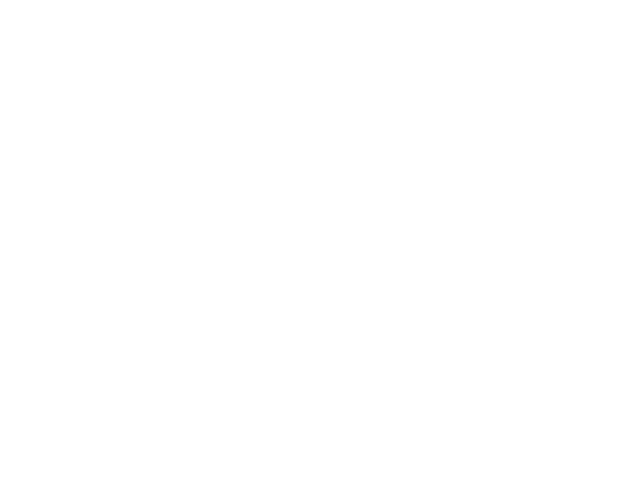

(<matplotlib.axes._subplots.AxesSubplot at 0x16288808>,
 <matplotlib.axes._subplots.AxesSubplot at 0x162bdf88>)

In [28]:
visualise_call(noisy_synth_call, fs)

In [29]:
output = ui.segment_and_measure_call(noisy_synth_call, fs,
                                         segment_method='pwvd',
                                          fmrate_threshold=0.5,
                                         sample_every=0.1*10**-3,
                                         percentile=99.9
                                        )
seg_output, call_parts, measurements, backg_output = output

In [30]:
measurements

,start,stop,duration,region_id
0,0.000000,0.001179,0.001179,fm1
1,0.001179,0.010771,0.009592,cf1
2,0.010771,0.013968,0.003197,fm2


In [31]:
0.84*0.96*0.97

0.7822079999999999

In [32]:
0.001/0.001179

0.8481764206955047

<IPython.core.display.Javascript object>


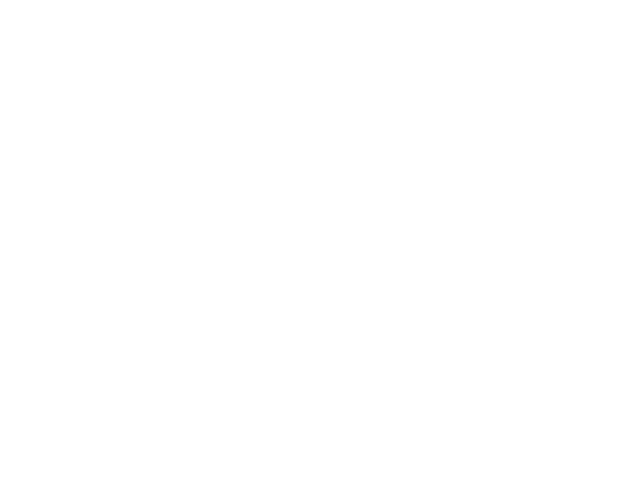

In [33]:
plt.figure()
plt.plot(seg_output[-1]['fmrate'])

<IPython.core.display.Javascript object>


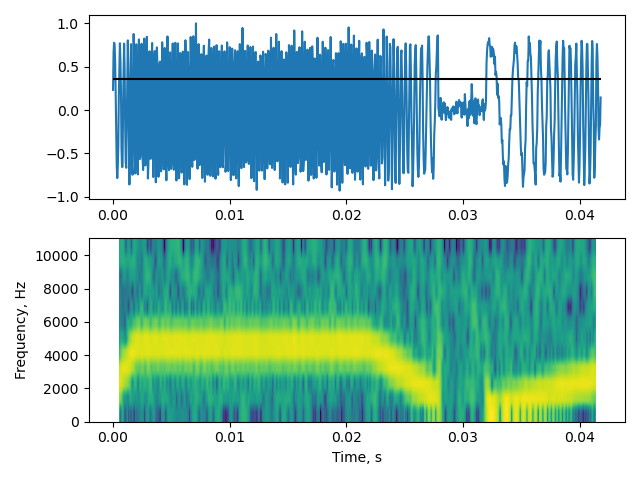

In [45]:
w,s = visualise_call(noisy_w_sweep, fs)
w.hlines(10**(-9/20.0),0,noisy_w_sweep.size/fs, zorder=4)

In [35]:
output = ui.segment_and_measure_call(noisy_w_sweep, fs,
                                         segment_method='pwvd',
                                          fmrate_threshold=0.5,
                                         sample_every=0.1*10**-3,
                                         background_noise=-6.5
                                        )
seg_output, call_parts, measurements, backg_output = output
measurements

,start,stop,duration,region_id
0,0.000000,0.001179,0.001179,fm1
1,0.001179,0.008889,0.007710,cf1
2,0.008889,0.008957,0.000068,fm2
3,0.008957,0.009161,0.000204,cf2
4,0.009161,0.009229,0.000068,fm3
5,0.009229,0.009524,0.000295,cf3
6,0.009524,0.009592,0.000068,fm4
7,0.009592,0.010794,0.001202,cf4
8,0.010794,0.016395,0.005601,fm5
9,0.016395,0.016508,0.000113,cf5


In [36]:
output = ui.segment_and_measure_call(noisy_w_sweep, fs,
                                         segment_method='peak_percentage',
                                          peak_percentage=0.999,
                                         background_noise=-9,
                                         window_size=250
                                        )
seg_output, call_parts, measurements, backg_output = output
measurements

,start,stop,duration,region_id
0,0.000000,0.000658,0.000658,fm1
1,0.000658,0.005669,0.005011,cf1
2,0.005669,0.020952,0.015283,fm2


### What about weird bird type sounds: 
Here, let's make a bird-type call, with an upFM, Cf, upfm and then a final CF

In [37]:
help(make_fm_chirp)

Help on function make_fm_chirp in module measure_horseshoe_bat_calls.simulate_calls:

make_fm_chirp(start_f, end_f, durn, fs, chirp_type='linear')



In [38]:
fs = 22100
song_gap = silence(0.005,fs)
all_call_parts = [
                  make_fm_chirp(100,5000,0.010,fs),
                  song_gap,
                  make_tone(5000,0.01,fs),
                  song_gap,
                  make_fm_chirp(5000,7000,0.01,fs),
                 song_gap,
                  make_tone(8000,0.01,fs)]
fake_bird_song = np.concatenate(all_call_parts)

In [39]:
song_gap.size

110

In [40]:
4900/10

490.0

In [41]:
Audio(fake_bird_song, rate=fs)

<IPython.core.display.Javascript object>


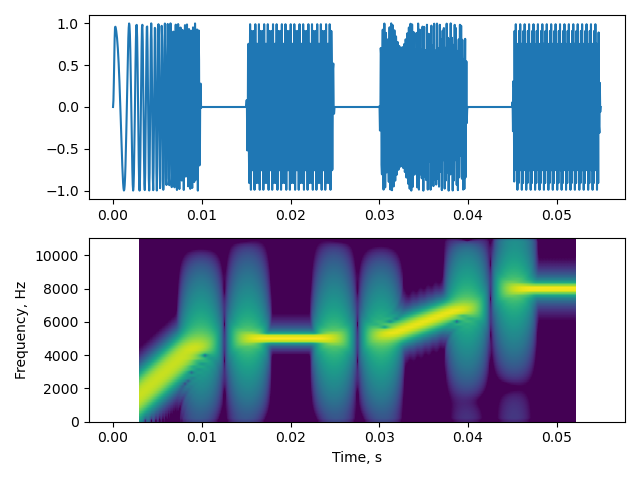

(<matplotlib.axes._subplots.AxesSubplot at 0x165b05c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x16d33b48>)

In [44]:
visualise_call(fake_bird_song, fs, fft_size=128)